In [1]:
# !pip install datasets
# !pip install einops
# !pip install denoising_diffusion_pytorch
from denoising_diffusion_pytorch import Unet
from inspect import isfunction
from einops import rearrange
import einops
from functools import partial
from torch import nn, einsum
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
import random
import math

/mnt/align3_drive/adrianoh/miniconda3/envs/dl-pset3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fashion MNIST

This dataset is very similar to MNIST, but instead of 10 digits we have 10 types of clothing. For this pset, the labels are not important, and we are only trying to sample from the data distribution $p_\texttt{data}$. Because we are now in the regime of unsupervised learning, we will only use the 60k datapoint training data and disregard the test data.

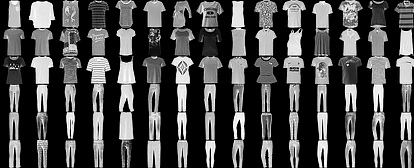


In [15]:
SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
LR = 1e-3

device = torch.device("cuda")
train = FashionMNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
train_loader = dataloader.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

# VAE Architecture

Typically VAEs that operate on images use convolutions and deconvolutions, but in this problem we will simply flatten the input and use an MLP.

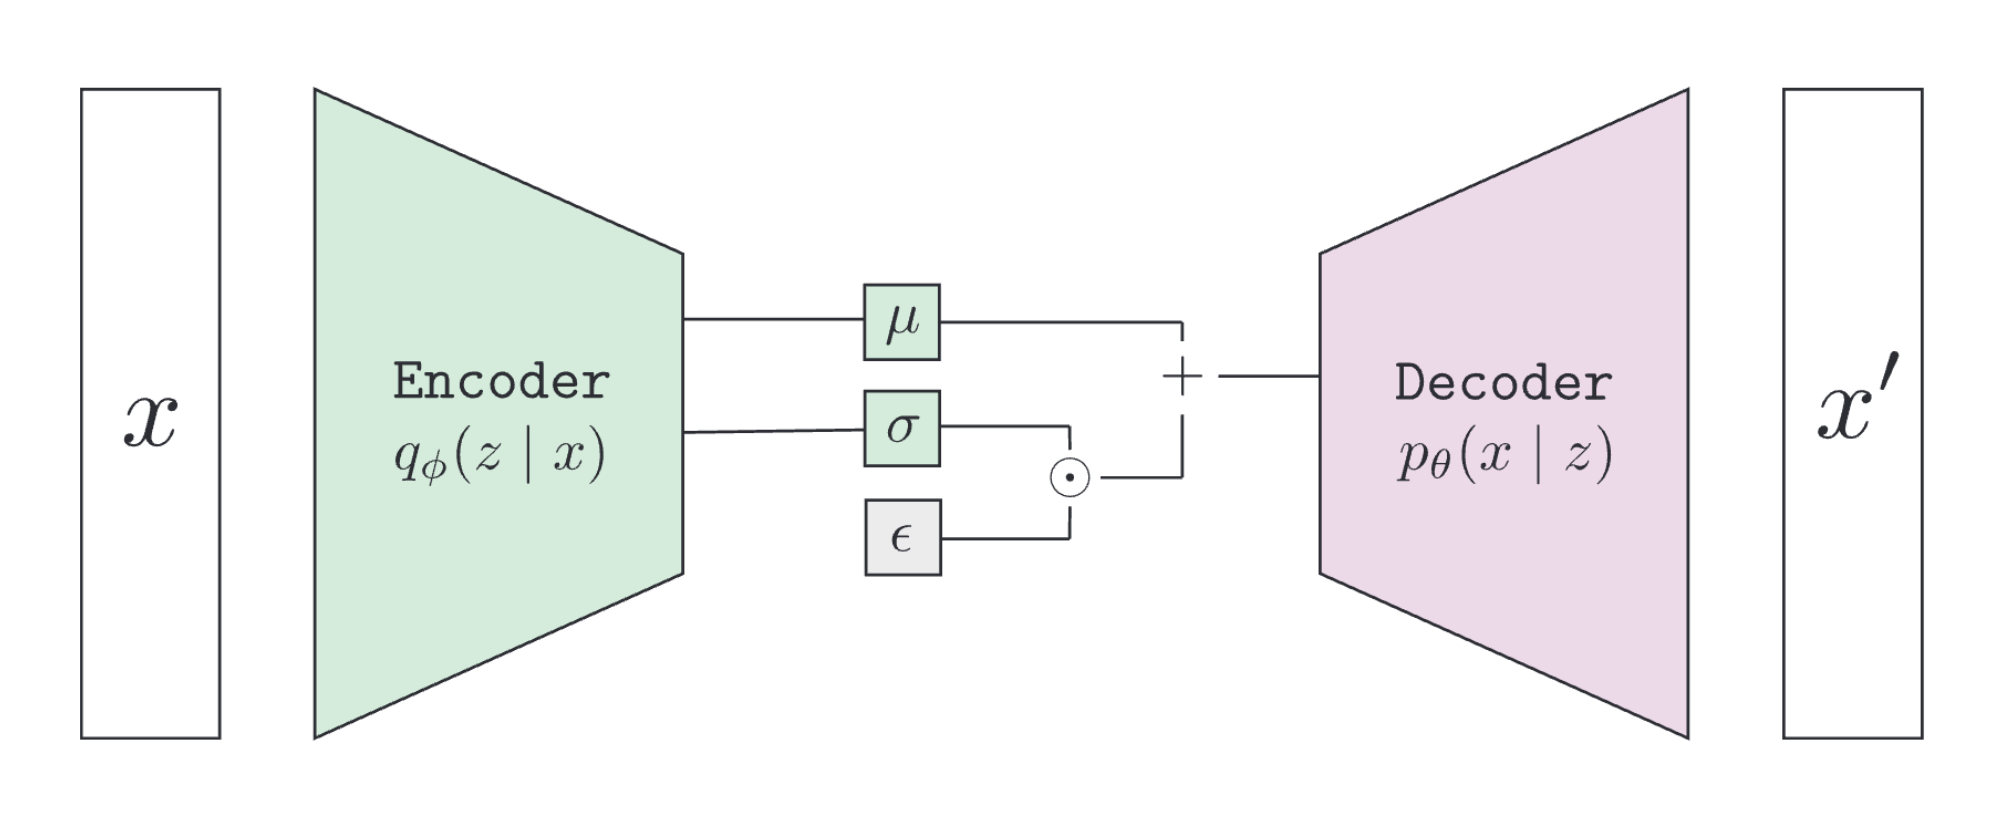

**Question 4:** Implement the VAE architecture

- Inside the `__init__` function you will need to create four modules.
- The `encoder` module should have two layers with each layer having `num_hidden` hidden units. Both layers should use `nn.ReLU` nonlinearities.
- The `mu` readout module and `logvar` readout module should be a single linear layer with no nonlinearities that maps from `num_hidden` units to `z_dims` units. `z_dims` is the size of the latent representation.
- The `decoder` module should have three layers. The first two layers should have `num_hidden` hidden units and `nn.ReLU` nonlinearities, and the last layer should map to the input size and use a `nn.Sigmoid` nonlinearity.

- The `forward` function is where you should pass your data through those modules according to the figure above. The output of this function should be a 3-tuple containing the reconstructed image, the mean from the `mu` readout module, and the log of the variance from the `logvar` readout module.
  - HINT 1: To create the z that you pass into the decoder, you will need to sample from a zero-mean unit variance gaussian $\epsilon$ with `torch.randn_like`. You latent should be a transformation of that sample as follows:
    $$z=\mu+\sigma\epsilon. $$
    This is typically referred to as the "reparameterization trick."
  - HINT 2: For stability during training, the `logvar` readout module does not output the standard deviation directly, but the log of the variance. You will need to transform appropriately when sampling z.


In [17]:
class VAE(nn.Module):
    def __init__(self, z_dims=4, input_size=784, num_hidden=128):
        super().__init__()
        self.z_dims = z_dims
        self.input_size = input_size

        # FIXED: Create two encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
        )

        # FIXED: Create the mean and logvar readout layers
        self.mu = nn.Linear(num_hidden, z_dims)
        self.logvar = nn.Linear(
            num_hidden, z_dims
        )  # different axis -> different global units

        # FIXED: Create the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(z_dims, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # FIXED: Implement the VAE forward function
        assert len(x.shape) <= 2, "Expected a 2D (flat) tensor"
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # normal random isotropic
        z = mu + std * eps
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [ ]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)  # , betas=(0.5, 0.5))

**Question 5:** Train the VAE. A lot of the code for training the VAE is given. You only need to come up with the $L_{\text{ELBO}}$ loss given `x_prime`, `mu`, and `logvar`.

- HINT: The KL Divergence between two gaussians $q_1=N(\mu_1,\sigma_1)$ and $q_2=N(\mu_2,\sigma_2)$ is defined as follows:

$$ D\_{\text{KL}}(q_1 \parallel q_2) = log\Big(\frac{\sigma_2}{\sigma_1}\Big) + \frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$


**Expected runtime is ~10 seconds per epoch**


In [18]:
def loss_function(x_prime, mu_z, logvar_z):
    reconstruction_losses = 0.5 * F.mse_loss(x_prime, X, reduction="sum") / batch_size
    assert len(mu_z.shape) == 2, f"mu_z.shape = {mu_z.shape} must be 2D"
    assert len(logvar_z.shape) == 2, f"logvar_z.shape = {logvar_z.shape} must be 2D"
    kl_loss = 0.5 * torch.sum(
        mu_z**2 + torch.exp(2 * logvar_z) - logvar_z, dim=-1
    )  # sum over latent dimensions
    assert kl_loss.shape == (batch_size,), f"kl_loss.shape = {kl_loss.shape} must be 1D"
    kl_loss = kl_loss.mean()  # average over batch
    loss = reconstruction_losses + kl_loss
    return loss


for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for X, _ in tqdm(train_loader):
        batch_size, _, _, _ = X.shape
        assert (
            0.0 <= X.min().item() and X.max().item() <= 1.0
        ), "Expected normalized data"  # <--- sigmoid sanity
        X = X.cuda()
        X = X.flatten(start_dim=1)  # ignore da batch
        optimizer.zero_grad()
        x_prime, mu_z, logvar_z = model(X)
        # NOTE that p(z) is a isotropic gaussian centered at zero

        # FIXED: Calculate loss; NOTE: we ignore the constant in KL since it shouldn't matter
        # from: https://www.dropbox.com/scl/fi/jy9u21sqa4zjpkhzyygue/15_gen_models_2.pdf?rlkey=4c7i4evuoxeaskaqu8zzc0qo6&e=1&dl=0
        # also helpful: https://www.youtube.com/watch?v=afNuE5z2CQ8 and Panopto
        #
        # NOTE also that this is assumed to be an ISOTROPIC GAUSSIAN of x | z, so we are having sigma_x = 1
        # (the question picture makes it seem like this?) and then we are ignoring the term also that has a constant
        # amount contributed to the reconstruction since a constant amount does not affect the optimization
        #
        # print(x_prime.shape, X.shape, mu_z.shape, logvar_z.shape) # DEBUG
        loss = loss_function(x_prime, mu_z, logvar_z)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(
        "Epoch: {} Train Loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )

100%|██████████| 469/469 [00:19<00:00, 24.32it/s]


Epoch: 0 Train Loss: 0.1965


100%|██████████| 469/469 [00:18<00:00, 24.72it/s]


Epoch: 1 Train Loss: 0.1518


100%|██████████| 469/469 [00:18<00:00, 25.36it/s]


Epoch: 2 Train Loss: 0.1430


100%|██████████| 469/469 [00:18<00:00, 24.87it/s]


Epoch: 3 Train Loss: 0.1392


100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Epoch: 4 Train Loss: 0.1376


100%|██████████| 469/469 [00:18<00:00, 25.55it/s]


Epoch: 5 Train Loss: 0.1368


100%|██████████| 469/469 [00:18<00:00, 25.61it/s]


Epoch: 6 Train Loss: 0.1359


100%|██████████| 469/469 [00:18<00:00, 25.29it/s]


Epoch: 7 Train Loss: 0.1352


100%|██████████| 469/469 [00:18<00:00, 24.71it/s]


Epoch: 8 Train Loss: 0.1348


100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


Epoch: 9 Train Loss: 0.1345


100%|██████████| 469/469 [00:18<00:00, 24.99it/s]


Epoch: 10 Train Loss: 0.1341


100%|██████████| 469/469 [00:19<00:00, 24.60it/s]


Epoch: 11 Train Loss: 0.1338


100%|██████████| 469/469 [00:14<00:00, 31.71it/s]


Epoch: 12 Train Loss: 0.1334


100%|██████████| 469/469 [00:14<00:00, 32.58it/s]


Epoch: 13 Train Loss: 0.1332


100%|██████████| 469/469 [00:18<00:00, 25.10it/s]


Epoch: 14 Train Loss: 0.1329


100%|██████████| 469/469 [00:18<00:00, 25.07it/s]


Epoch: 15 Train Loss: 0.1328


100%|██████████| 469/469 [00:18<00:00, 25.43it/s]


Epoch: 16 Train Loss: 0.1325


100%|██████████| 469/469 [00:17<00:00, 26.65it/s]


Epoch: 17 Train Loss: 0.1323


100%|██████████| 469/469 [00:17<00:00, 26.41it/s]


Epoch: 18 Train Loss: 0.1323


100%|██████████| 469/469 [00:18<00:00, 25.90it/s]

Epoch: 19 Train Loss: 0.1319


**Question 6:** Complete the `plot_latents` function such that for a given pair of latent dimensions $(i, j)$ the `plot_latents` plots a grid of images sampled from different pairs of latent values in dimensions $i, j$. Latent dimensions not equal to $i$ or $j$ should be set to zero.

- Hint: You can implement this with a single call to `plt.imshow` by creating a 280x280 image and populating it incrementally with the outputs from `model.decoder(z)` for the different sampled latents z.


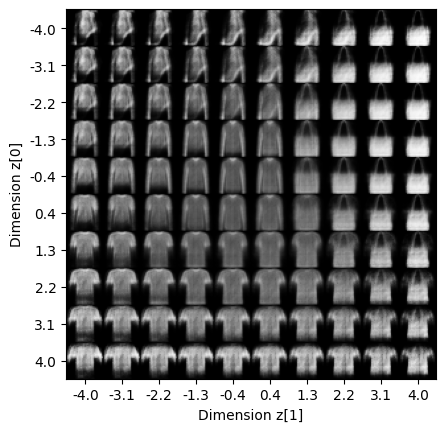

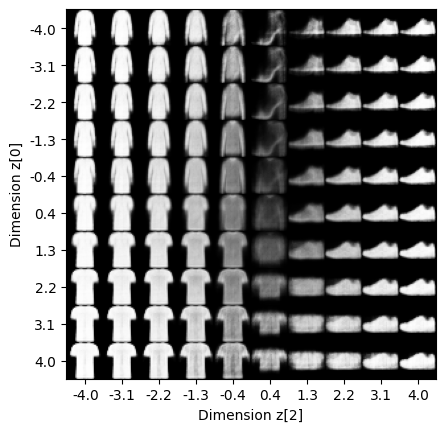

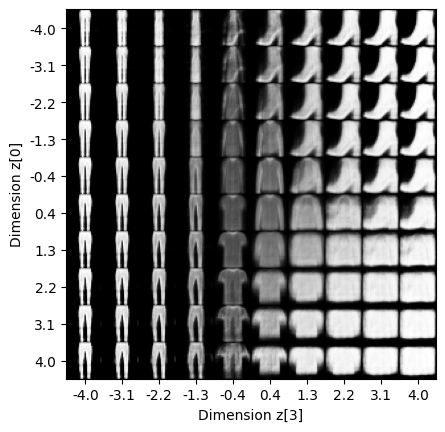

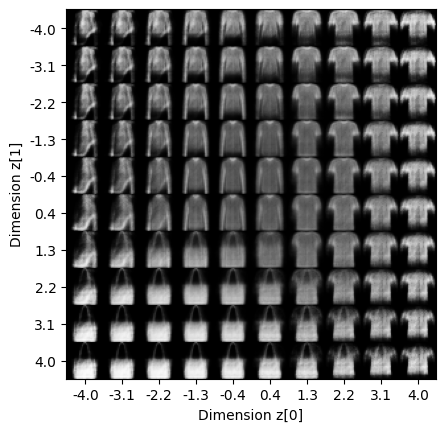

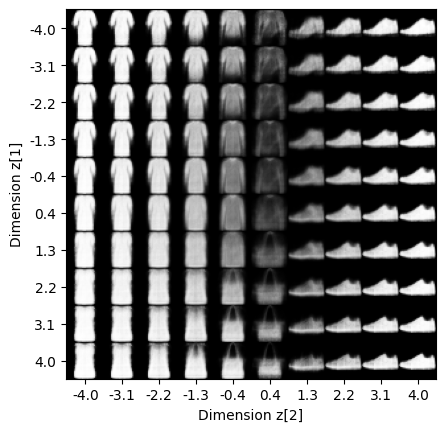

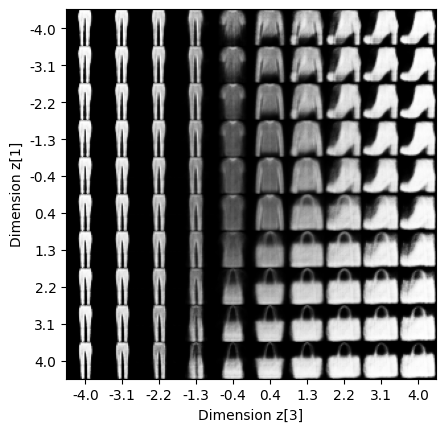

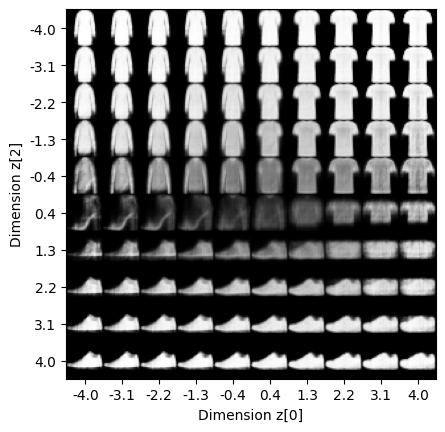

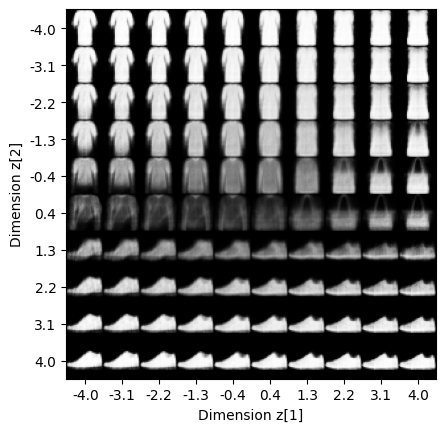

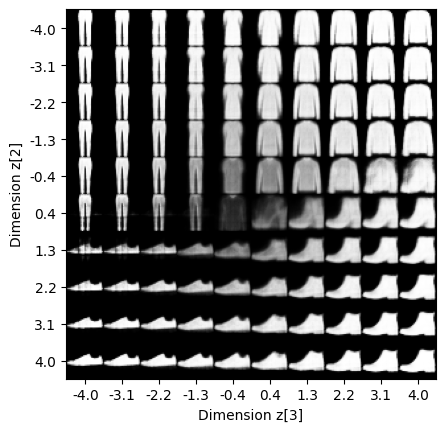

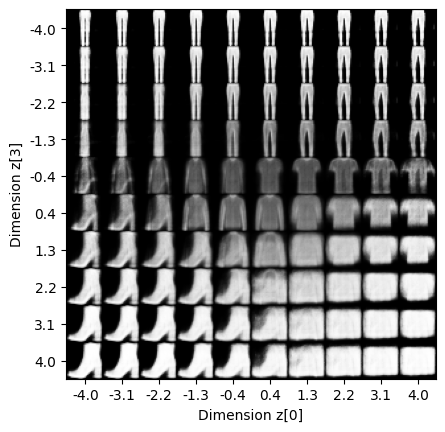

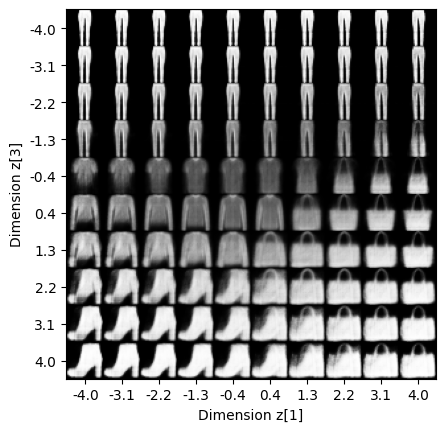

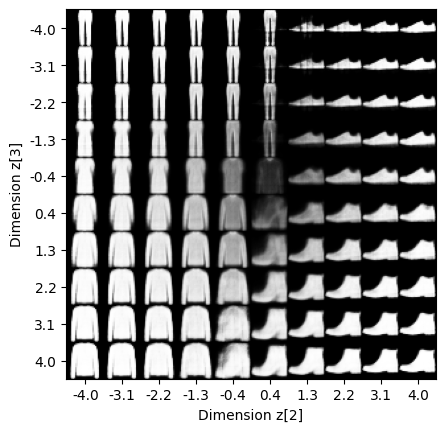

In [19]:
def plot_latents(
    model: nn.Module,
    i: int = 0,
    j: int = 1,
    smallest_val: float = -4.0,
    largest_val: float = 4.0,
    grid_size: int = 10,
):  # 4 stdev is a LOT (and what the question picture in latex suggests)
    # FIXED: Plot the image grid
    model_device = next(p.device for p in model.parameters())
    image_np = np.empty((28 * grid_size, 28 * grid_size))
    assert grid_size > 1, f"grid_size = {grid_size} must be positive"
    step_value_amount = (largest_val - smallest_val) / (grid_size - 1)
    for x_count, x in enumerate(
        range(0, 28 * grid_size, 28)
    ):  # each is a 28 x 28 image
        for y_count, y in enumerate(range(0, 28 * grid_size, 28)):
            assert 0 <= x_count < grid_size, f"x_count = {x_count} is out of bounds"
            assert 0 <= y_count < grid_size, f"y_count = {y_count} is out of bounds"
            # recall: this is an isotropic gaussian that we are trying to fit the images onto
            z = torch.zeros(model.z_dims).to(model_device)
            z[i] = step_value_amount * x_count + smallest_val
            z[j] = step_value_amount * y_count + smallest_val
            # print(z) # DEBUG: you'll see that only the correct entries are non-zero
            assert (
                smallest_val <= z[i] <= largest_val
            ), f"z[{i}] = {z[i]} is out of bounds"
            assert (
                smallest_val <= z[j] <= largest_val
            ), f"z[{j}] = {z[j]} is out of bounds"
            decoded = model.decoder(z)
            assert decoded.shape == (28 * 28,)
            image_np[x : x + 28, y : y + 28] = (
                decoded.detach().cpu().numpy().reshape(28, 28)
            )
    # label the axis as i for y and j for x
    plt.imshow(image_np, cmap="gray")
    plt.xlabel(f"Dimension z[{j}]")
    plt.ylabel(f"Dimension z[{i}]")
    # Create tick positions at each grid cell center
    tick_positions = np.arange(grid_size) * 28 + 14
    # Create tick labels based on step_value_amount
    tick_labels = [
        f"{smallest_val + (step_value_amount * i):.1f}" for i in range(grid_size)
    ]
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels)
    plt.show()


def plot_zs(model):
    for i in range(model.z_dims):
        for j in range(model.z_dims):
            if i != j:
                plot_latents(model, i, j)


plot_zs(model)

# Diffusion Models


**Question 11:** Complete the three FIXMEs in the below code.

- NOTE: For each of the FIXMEs in this problem, you are provided with a batch of random times `t`. You will need to index into `beta_t` with this time vector `t` to construct your outputs.

1. Calculate $\textbf{x}_t$ from $\textbf{x}_0$ and $\epsilon\sim N(0, \mathbf{I})$ using Equation 7. Note $\textbf{x}_t$ should have the same shape as $\textbf{x}_0$ and $\epsilon$.
2. Using the variance schedule `beta_t`, calculate `beta_tilde_t` using from the pset document.
3. Using the variance schedule `beta_t`, calculate `mu_tilde_t` using the pset document. `mu_tilde_t` should have the same shape as `x`.

**Your training should take around 2 minutes per epoch**


In [28]:
NUM_EPOCHS = 5
TOTAL_TIMESTEPS = 200
scaled_size = 32

# Create the Unet model
model = Unet(
    scaled_size,
    channels=1,
    dim_mults=(
        1,
        2,
        4,
    ),
).to(device)

# We will use the following variance schedule for our diffusion model
beta_t = torch.linspace(0.0001, 0.02, TOTAL_TIMESTEPS)


def forward_sample(
    x_0: torch.Tensor, t: torch.Tensor | int, e: torch.Tensor
) -> torch.Tensor:
    # FIXED: calculate x_t from x_0, e, and t using the equation provided in the homework
    assert len(t.shape) == 1
    assert len(x_0.shape) == 4, x_0.shape
    assert x_0.shape[0] == t.shape[0]
    # NOTE we could make this more effecient by grouping to min and etc...
    a_tilde_t = torch.Tensor(
        [torch.exp(torch.sum(torch.log(1 - beta_t[: t_ + 1]))) for t_ in t]
    )
    assert a_tilde_t.shape == (
        batch_size,
    ), f"a_tilde_t.shape = {a_tilde_t.shape} must be 1D"
    assert e.shape == x_0.shape
    assert e.shape[0] == batch_size
    a_tilde_t = einops.rearrange(a_tilde_t, "b -> b 1 1 1").to(
        x_0.device
    )  # make sure to broadcast OK
    assert e.device == x_0.device
    x_t = torch.sqrt(a_tilde_t) * x_0 + torch.sqrt(1 - a_tilde_t) * e
    return x_t


optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(NUM_EPOCHS):
    train_losses = []
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        batch_size = X.shape[0]
        batch = X.to(device)

        # Sample a batch of times for training
        t = torch.randint(0, TOTAL_TIMESTEPS, (batch_size,), device=device).long()

        # Calculate the loss
        e = torch.randn_like(batch)
        x_t = forward_sample(batch, t, e)
        e_pred = model(x_t, t)
        loss = F.mse_loss(e, e_pred)

        # Gradient step
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, np.mean(train_losses)))

100%|██████████| 469/469 [00:37<00:00, 12.57it/s]


Epoch: 0 Loss: 0.1124264122342377


100%|██████████| 469/469 [00:37<00:00, 12.48it/s]


Epoch: 1 Loss: 0.06712123429152503


100%|██████████| 469/469 [00:37<00:00, 12.66it/s]


Epoch: 2 Loss: 0.0584275786762934


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Epoch: 3 Loss: 0.053898170296507855


100%|██████████| 469/469 [00:37<00:00, 12.63it/s]

Epoch: 4 Loss: 0.05331764905564566


## Denoising with the learned model


In [85]:
def reverse_sample(model: nn.Module, x: torch.Tensor, t_index: int, mode: str = "longview") -> torch.Tensor:
    assert isinstance(model, nn.Module)
    assert isinstance(x, torch.Tensor)
    assert isinstance(t_index, int)

    # FIXED: Using beta_t, calculate beta_tilde_t using equation 5 from the pset document
    a_tilde_tm1 = torch.exp(torch.sum(torch.log(1 - beta_t[:t_index])))
    a_t = 1 - beta_t[t_index]
    a_tilde_t = a_tilde_tm1 * a_t
    scale = (1 - a_tilde_tm1) / (1 - a_tilde_t)

    beta_tilde_t = beta_t[t_index] * scale
    ########################

    # estimate x_0
    # note x_t = sqrt(a_tilde_t) * x_0 + sqrt(1 - a_tilde_t) * e
    # -> x_0 = (x_t - sqrt(1 - a_tilde_t) * e) / sqrt(a_tilde_t)
    e = model(x, time=torch.Tensor([t_index]).long().to(x.device))
    x_0 = (x - torch.sqrt(1 - a_tilde_t) * e) / torch.sqrt(a_tilde_t)

    # FIXED: Using beta_t, calculate mu_tilde_t using equation 6 from the pset document
    mu_tilde_t_short = (torch.sqrt(a_t) * scale).to(x.device) * x
    mu_tilde_t = mu_tilde_t_short + (torch.sqrt(a_tilde_t) * beta_t[t_index] / (1 - a_tilde_t)).to(x.device) * x_0  # fmt: skip
    ########################

    # A much better sampling procedure here is to just do algebra on 
    # x_t = sqrt(a_t) * x_{t-1} + sqrt(b_t) * e (where a_t + b_t = 1)
    # -> x_{t-1} = (x_t - sqrt(b_t) * e) / sqrt(a_t)
    if mode == "longview":
        return mu_tilde_t - torch.sqrt(beta_tilde_t) * e # <------- long viewpoint (what they ask for)
    elif mode == "shortview":
        return (x - torch.sqrt(beta_t[t_index]) * e) / torch.sqrt(a_t) # <----- short viewpoint
    elif mode == "longview_no_view":
        return mu_tilde_t_short - torch.sqrt(beta_tilde_t) * e # <------- long viewpoint (what they ask for)
    else:
        raise ValueError(f"Invalid mode: {mode}")

@torch.no_grad()
def sample(model, mode: str = "longview"):
    shape = (1, 1, scaled_size, scaled_size)
    img = torch.randn(shape, device=device)
    # original_img = img.clone()
    imgs = [img.cpu().numpy()]
    for i in tqdm(list(reversed(range(0, TOTAL_TIMESTEPS))), desc=f"Sampling {mode} view"):
        assert model is not None
        assert img is not None
        assert imgs is not None and len(imgs) > 0
        img = reverse_sample(model, img, i, mode)
        imgs.append(img.detach().cpu().numpy())
    return imgs

**Question 12:**
Use the calculated `samples` to visualize the model the diffusion model inference over time. Create a plot with six horizontally-aligned subfigures showing the diffusion model inference $x_t$ for $t\in{\{200, 100, 50, 20, 10, 0\}}$.


In [86]:
samples_longview = list(reversed(sample(model, mode="longview"))) # reverse so left is noisier
samples_shortview = list(reversed(sample(model, mode="shortview"))) # reverse so left is noisier
samples_longview_no_view = list(reversed(sample(model, mode="longview_no_view"))) # reverse so left is noisier

"""
NOTE PLEASE READ THIS COMMENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
- Longview: estimate x_0 from x_t using the equations (eq. 6, etc...) and then use that in the sampling procedure (eq. 4-7)
- Shortview: estimate x_{t-1} from x_t directly using algebraic manipulation of eq. 2
- Longview_no_view: same as longview, except does not estimate x_0
"""

Sampling longview_no_view view: 100%|██████████| 200/200 [00:02<00:00, 70.05it/s]


'\nNOTE PLEASE READ THIS COMMENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n- Longview: estimate x_0 from x_t using the equations (eq. 6, etc...) and then use that in the sampling procedure (eq. 4-7)\n- Shortview: estimate x_{t-1} from x_t directly using algebraic manipulation of eq. 2\n- Longview_no_view: same as longview, except does not estimate x_0\n'

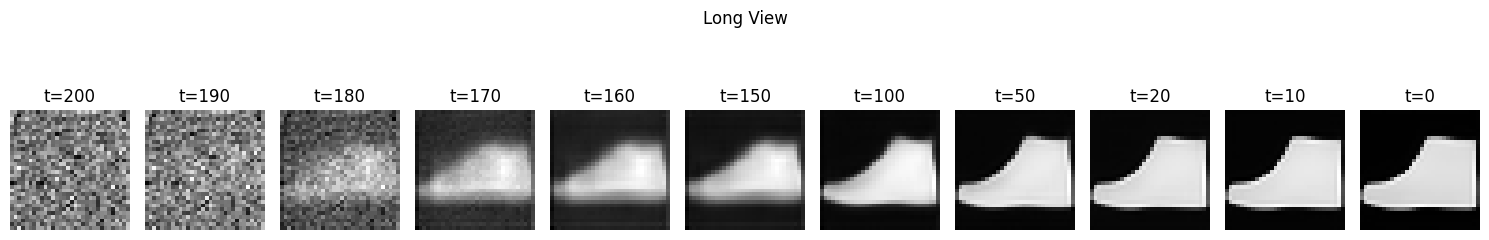

In [87]:
# FIXED
time_steps = [200, 190, 180, 170, 160, 150, 100, 50, 20, 10, 0] # <--- we add a couple more points to understand
plt.figure(figsize=(15, 3))  # Make the figure wider to accommodate all 6 images
plt.suptitle("Long View")
for idx, t in enumerate(time_steps):
    plt.subplot(1, len(time_steps), idx + 1)  # Use idx + 1 instead of t // 50 + 1
    plt.imshow(samples_longview[t].reshape(scaled_size, scaled_size), cmap="gray")
    plt.title(f't={t}')
    plt.axis("off")
plt.tight_layout()
plt.show()


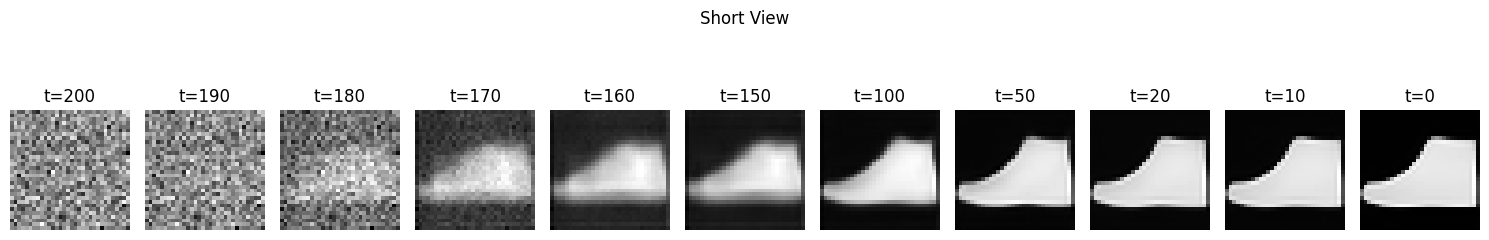

In [88]:
# FIXED
time_steps = [200, 190, 180, 170, 160, 150, 100, 50, 20, 10, 0] # <--- we add a couple more points to understand
plt.figure(figsize=(15, 3))  # Make the figure wider to accommodate all 6 images
plt.suptitle("Short View")
for idx, t in enumerate(time_steps):
    plt.subplot(1, len(time_steps), idx + 1)  # Use idx + 1 instead of t // 50 + 1
    plt.imshow(samples_shortview[t].reshape(scaled_size, scaled_size), cmap="gray")
    plt.title(f't={t}')
    plt.axis("off")
plt.tight_layout()
plt.show()


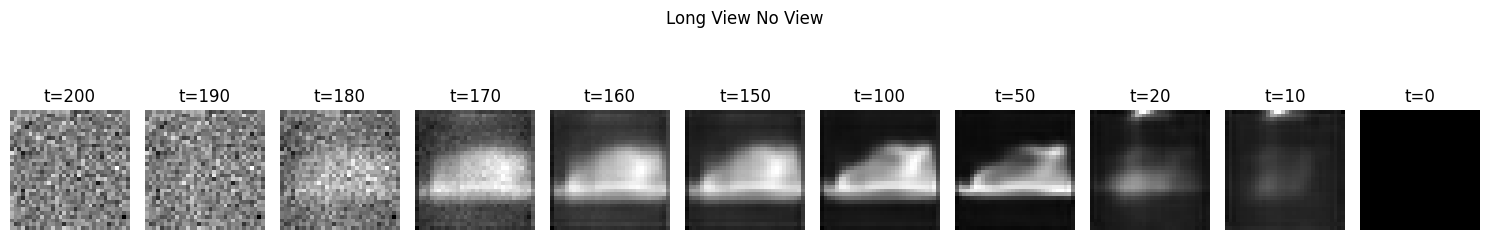

In [89]:
# FIXED
time_steps = [200, 190, 180, 170, 160, 150, 100, 50, 20, 10, 0] # <--- we add a couple more points to understand
plt.figure(figsize=(15, 3))  # Make the figure wider to accommodate all 6 images
plt.suptitle("Long View No View")
for idx, t in enumerate(time_steps):
    plt.subplot(1, len(time_steps), idx + 1)  # Use idx + 1 instead of t // 50 + 1
    plt.imshow(samples_longview_no_view[t].reshape(scaled_size, scaled_size), cmap="gray")
    plt.title(f't={t}')
    plt.axis("off")
plt.tight_layout()
plt.show()
